In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
#using Printf

include("src/timeseries.jl")
rc("font", family="sans-serif", size=16)

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


In [2]:
overview_df = CSV.read("paper_eval\\overview.csv")
overview_tssa_df = CSV.read("tssa_experiments\\overview.csv")
efficiency_factor = 5.0

function load_tssa_experiment(name)
    df = CSV.read("tssa_experiments\\$(name).csv")
    df[:GA_time] /= efficiency_factor
    df[:HA_time] /= efficiency_factor
    return df
end

function load_my_experiment(name)
    return CSV.read("paper_eval\\$(name).csv")
end

function getExperimentsAndLabelsTssa(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints, overview_tssa_df)
    return [(relevantEntries[:name][i], relevantEntries[:algo][i]) for i in 1:size(relevantEntries, 1)]
end

function getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints, overview_df)
    results = [("name", "label") for i in 1:size(relevantEntries, 1)]
    for i in 1:size(relevantEntries, 1)
        label = "unclassified"
        if relevantEntries[:loop][i]
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "GA-L"
            else
                label = "GA-SL"
            end
        else
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "GA-B"
            else
                label = "GA-S"
            end
        end
        results[i] = (relevantEntries[:name][i], label)
    end
    results_sorted = []
    append!(results_sorted, filter(res -> res[2] == "GA-B", results))
    append!(results_sorted, filter(res -> res[2] == "GA-S", results))
    append!(results_sorted, filter(res -> res[2] == "GA-L", results))
    append!(results_sorted, filter(res -> res[2] == "GA-SL", results))
    return results_sorted
end

getExperimentsAndLabelsMy (generic function with 1 method)

In [3]:
function min_value_after(df, time_dim, value_dim, t)
    filtered = filter(row -> row[time_dim] <= t, df)
    if size(filtered, 1) == 0
        return Inf
    end
    return minimum(filtered[value_dim])
end

function showEarliestCompletionTime(df, time_dim)
    runs_df = by(df, :run_id) do run_df
        completion_time = maximum(run_df[time_dim])
    end
    @show minimum(runs_df[:x1])
end

function getCheckpointAverages(df, time_dim, value_dim, time_checkpoints)
    showEarliestCompletionTime(df, time_dim)
    average_values = []
    for t in time_checkpoints
        runs_df = by(df, :run_id) do run_df
            best_value = min_value_after(run_df, time_dim, value_dim, t)
        end
        append!(average_values, mean(runs_df[:x1]))
    end
    return average_values
end

function plotProblem(dataset, consideredLength, remainingPoints, time_checkpoints, allowed_my=["GA-B", "GA-S", "GA-L", "GA-SL"])
    experiments_and_labels_my = getExperimentsAndLabelsMy(dataset, consideredLength, remainingPoints)
    experiments_and_labels_my = filter(pair -> pair[2] in allowed_my, experiments_and_labels_my)
    experiments_and_labels_tssa = getExperimentsAndLabelsTssa(dataset, consideredLength, remainingPoints)
    @show
    for pair in experiments_and_labels_my
        @show pair[1]
        values = getCheckpointAverages(load_my_experiment(pair[1]), :total_time, :best_valid_mse, time_checkpoints)
        plot(time_checkpoints, values, label=pair[2])
    end
    for pair in experiments_and_labels_tssa
        @show pair[1]
        #values = getCheckpointAverages(load_tssa_experiment(pair[1]), :GA_time, :GA_MSE, time_checkpoints)
        #plot(time_checkpoints, values, label=pair[2]*" (no LS)")
        values = getCheckpointAverages(load_tssa_experiment(pair[1]), :HA_time, :HA_MSE, time_checkpoints)
        plot(time_checkpoints, values, label=pair[2]*" (with LS)")
    end
    #bellman_result, bellman_looped_result = getBellman(dataset, consideredLength, remainingPoints)
    #plot([0, 500], [bellman_result, bellman_result], color="gray", linestyle="dashed", label="Bellman")
    title("$dataset[1:$consideredLength], down to $remainingPoints points")
    ylabel("avg. best mse")
    xlabel("adapted WCT in seconds")
    #yscale("log")
    legend()
    #xlim((0, 500))
    grid()
end

plotProblem (generic function with 2 methods)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = getExperimentsAndLabelsMy(::String, ::Int64, ::Int64) at In[2]:26
└ @ Main .\In[2]:26
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = getExperimentsAndLabelsMy(::String, ::Int64, ::Int64) at In[2]:0
└ @ Main .\In[2]:0
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = getExperimentsAndLabelsMy(::String, ::Int64, ::Int64) at In[2]:39
└ @ Main .\In[2]:39
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = (::var"#22#24"{DataFrame})(::Int64) at none:0
└ @ Main .\none:0
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = (::var"#22#24"{DataFrame})(::Int64) at none:0
└ @ Main .\none:0


pair[1] = "ASCROTSS_2020-1-5-23-38-20"


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = load_tssa_experiment(::String) at In[2]:7
└ @ Main .\In[2]:7
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = load_tssa_experiment(::String) at In[2]:7
└ @ Main .\In[2]:7
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = load_tssa_experiment(::String) at In[2]:8
└ @ Main .\In[2]:8
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = load_tssa_experiment(::String) at In[2]:8
└ @ Main .\In[2]:8
┌ Warning: `getindex(sdf::SubDataFrame, colind::ColumnIndex)` is deprecated, use `sdf[!, colind]` instead.
│   caller = (::var"#39#40"{Symbol})(::SubDataFrame{DataFrame,DataFrames.Index,

minimum(runs_df[:x1]) = 264.7386


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = getCheckpointAverages(::DataFrame, ::Symbol, ::Symbol, ::StepRange{Int64,Int64}) at In[3]:23
└ @ Main .\In[3]:23


pair[1] = "DBBePSOTSS_2020-1-2-6-18-31"


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = min_value_after(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}, ::Symbol, ::Symbol, ::Int64) at In[3]:6
└ @ Main .\In[3]:6


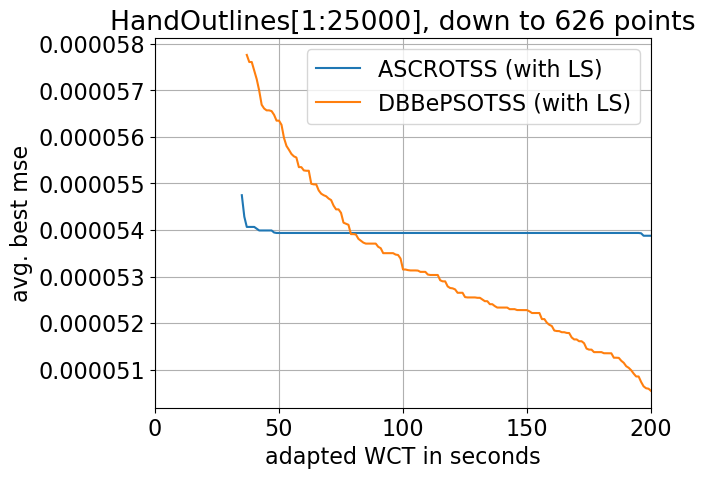

minimum(runs_df[:x1]) = 852.0698


(0, 200)

In [4]:
plotProblem("HandOutlines", 25000, 626, 0:1:200, [])#["GA-B"], "GA-S", "GA-L", "GA-SL"])
xlim((0,200))
#ylim((0, 0.00002))
#savefig("example_ga_plot", bbox_inches="tight")

In [5]:
pygui(true)

true